### Memanggil modul - modul yang digunakan

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/cleaned_twitter.csv')
df.head()

,sentimen,Tweet
0,1.0,menitik air mata saya terbayang betapa terseks...
1,1.0,kalau bnda itu jadi lagi saya mals deh ingin m...
2,1.0,complicated betul saya usha dak ptptn
3,1.0,haruskah unfollow semua olshop yang seliweran ...
4,1.0,saya pamit dan jangan cari saya


In [3]:
# Checking for null values
df.isna().sum()

sentimen      0
Tweet       417
dtype: int64

In [4]:
# Import Module
from sklearn.impute import SimpleImputer

# Pembuatan Imputation dengan pengganti modus
impute_modes = SimpleImputer(strategy='most_frequent')

df['Tweet'] = impute_modes.fit_transform(df[['Tweet']])

In [5]:
# Checking for null values
df.isna().sum()

sentimen    0
Tweet       0
dtype: int64

In [6]:
tweets = df['Tweet']
tweets.head()

0    menitik air mata saya terbayang betapa terseks...
1    kalau bnda itu jadi lagi saya mals deh ingin m...
2                complicated betul saya usha dak ptptn
3    haruskah unfollow semua olshop yang seliweran ...
4                      saya pamit dan jangan cari saya
Name: Tweet, dtype: object

In [7]:
max_len = 0
max_words = ''
unique_words = set()
for tweet in tweets.str.split():
    if not tweet:
        continue
    tweet_max = max(tweet, key=len)
    unique_words.update(tweet)
    if max_len < len(tweet_max):
        max_len = len(tweet_max)
        max_words = tweet_max

print(f"{max_len=}\n{max_words=}\n{len(unique_words)=}")

max_len=39
max_words='sejukatgasnusantaraatgasnusantarakaltim'
len(unique_words)=13284


In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

y = df["sentimen"]
#mengubah y menjadi integer
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print(y[0:10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenisasi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [13]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('Dataset has %s number of independent tokens' %V)

Dataset has 13283 number of independent tokens


In [14]:
encoded_comments = tokenizer.texts_to_sequences(tweets)
print(encoded_comments[0:10])

[[4717, 495, 263, 1, 4718, 958, 4719, 321, 1888, 3021, 10, 296, 4720, 52, 2292, 3022, 1591, 1889, 1405], [13, 4721, 10, 15, 35, 1, 4722, 205, 65, 4723], [2293, 22, 1, 3023, 2294, 4724], [4725, 4726, 48, 3024, 2, 4727, 12, 686, 8, 36, 4728, 106, 1, 4729, 13, 12, 4730], [1, 3025, 5, 36, 163, 1], [1, 3026, 4731, 185, 31, 353, 14, 3027, 76, 33, 760, 33, 48, 2, 41, 1890], [461, 57, 6, 1, 12, 54, 377], [1891, 4732, 184, 4733, 8, 1, 1406, 17, 1042, 4734], [1, 53, 220, 42, 127, 1, 559, 4735, 16, 1, 442, 1269, 901], [3028, 560, 1, 35, 246, 4736]]


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=max_len)
    return padded
X = get_sequences(tokenizer, tweets)

In [16]:
print('Shape of X is ', X.shape)
print('Shape of y is', y.shape)

Shape of X is  (6664, 39)
Shape of y is (6664, 2)


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, stratify = y_train)

In [18]:
print(f'Bentuk X_train = {x_train.shape}',
      f'Bentuk Y_train = {y_train.shape}',
      f'Bentuk X_test = {x_test.shape}',
      f'Bentuk Y_test = {y_test.shape}', 
      f'Bentuk X_val = {x_val.shape}',
      f'Bentuk Y_val = {y_val.shape}',sep="\n")

Bentuk X_train = (3998, 39)
Bentuk Y_train = (3998, 2)
Bentuk X_test = (1333, 39)
Bentuk Y_test = (1333, 2)
Bentuk X_val = (1333, 39)
Bentuk Y_val = (1333, 2)


### Standarisasi

In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

### Membuat Model

In [20]:
from tensorflow.keras.layers import Dense, Embedding,Dropout,LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras import Sequential
model = Sequential([
Embedding(10000,16,input_length=max_len),
GlobalMaxPooling1D(),
Dense(2, activation='sigmoid')
])
model.compile(
     loss='categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

### Fitting Model yang dibikin

In [21]:
h = model.fit(
     x_train, y_train,
     validation_data=(x_val, y_val),
     epochs=20,
)

Epoch 1/20
125/125 [==============================] - 3s 12ms/step - loss: 0.6475 - accuracy: 0.6181 - val_loss: 0.5880 - val_accuracy: 0.7562
Epoch 2/20
125/125 [==============================] - 1s 6ms/step - loss: 0.4931 - accuracy: 0.8454 - val_loss: 0.4019 - val_accuracy: 0.8755
Epoch 3/20
125/125 [==============================] - 1s 6ms/step - loss: 0.3374 - accuracy: 0.8747 - val_loss: 0.2997 - val_accuracy: 0.8755
Epoch 4/20
125/125 [==============================] - 1s 6ms/step - loss: 0.2756 - accuracy: 0.8739 - val_loss: 0.2648 - val_accuracy: 0.8770
Epoch 5/20
125/125 [==============================] - 1s 6ms/step - loss: 0.2537 - accuracy: 0.8769 - val_loss: 0.2512 - val_accuracy: 0.8732
Epoch 6/20
125/125 [==============================] - 1s 7ms/step - loss: 0.2443 - accuracy: 0.8754 - val_loss: 0.2448 - val_accuracy: 0.8732
Epoch 7/20
125/125 [==============================] - 1s 7ms/step - loss: 0.2386 - accuracy: 0.8769 - val_loss: 0.2415 - val_accuracy: 0.8702
Epoch

In [24]:
model.save('model/model_PA_Final.h5')

In [25]:
# tf.keras.models.load_model()

# model.load_model('model/model_PA_Final.h5')

C:\Users\muham\AppData\Local\Temp\ipykernel_13200\1418931965.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co-" (-> color='c'). The keyword argument will take precedence.
  plt.plot(x,h.history['accuracy'],'co-',c='blue', label='accuracy')
C:\Users\muham\AppData\Local\Temp\ipykernel_13200\1418931965.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bD--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,h.history['val_accuracy'],'bD--',c='red', label='validation accuracy')


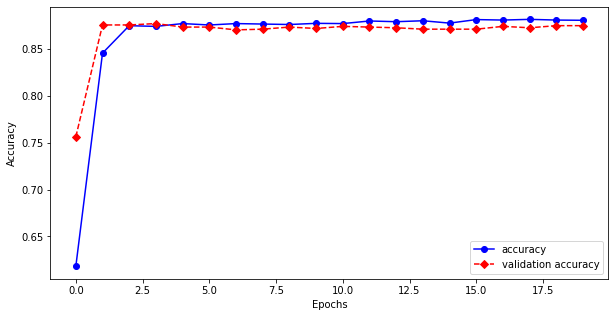

C:\Users\muham\AppData\Local\Temp\ipykernel_13200\1418931965.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co-" (-> color='c'). The keyword argument will take precedence.
  plt.plot(x,h.history['loss'],'co-', c='blue', label='loss')
C:\Users\muham\AppData\Local\Temp\ipykernel_13200\1418931965.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bD--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,h.history['val_loss'],'bD--',c='red', label='validation loss')


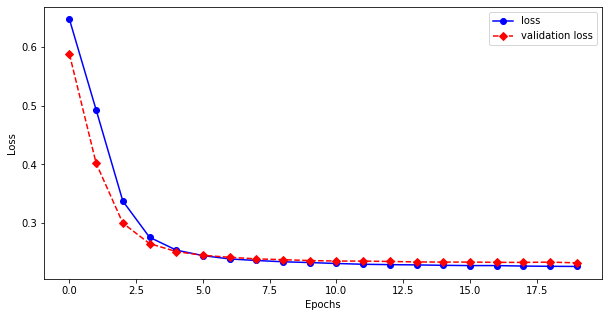

In [22]:
import matplotlib.pyplot as plt
plt.figure(1, (10,5))
x = range(len(h.history['accuracy']))
plt.plot(x,h.history['accuracy'],'co-',c='blue', label='accuracy')
plt.plot(x,h.history['val_accuracy'],'bD--',c='red', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(2, (10,5))
x = range(len(h.history['accuracy']))
plt.plot(x,h.history['loss'],'co-', c='blue', label='loss')
plt.plot(x,h.history['val_loss'],'bD--',c='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model.evaluate(x_test,y_test)

42/42 [==============================] - 0s 3ms/step - loss: 0.2260 - accuracy: 0.8830


[0.22595113515853882, 0.8829707503318787]

In [48]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLDS = (0.4, 0.8)
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEGATIVE
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        return label
    else:
        if score < 0.6:
            return NEGATIVE
        else:
            return POSITIVE

In [49]:
def prediksi_kata(text, include_neutral=True):
    # start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)
    # Predict
    score = model.predict([x_test])[0][1]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=False)

    return {"label": label, "score": float(score)} 
    

### Prediksi Kata Positive

In [50]:
prediksi_kata("saya lebih puyeng sudah")

1/1 [==============================] - 0s 41ms/step


{'label': 'POSITIVE', 'score': 0.9723116159439087}

### Prediksi Kata Negative

In [51]:
prediksi_kata("goblok kau pantek")

1/1 [==============================] - 0s 48ms/step


{'label': 'NEGATIVE', 'score': 0.5101654529571533}